1. Loading and Understanding the Dataset

In [50]:
# Import necessary libraries
!pip install shap
!pip install lime
!pip install tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from tabulate import tabulate  # To create a table format for the metrics
import shap  # For SHAP values
import lime
import lime.lime_tabular
from sklearn.metrics import roc_auc_score, roc_curve







In [2]:
# Load the dataset
dataset = pd.read_csv('dataset_churn.csv')

In [3]:
# Display the first few rows
print(dataset.head())


   Unnamed: 0                            CustomerID   Age  Gender  Tenure  \
0           0  08729464-bde6-43bc-8f63-a357096feab1  56.0    Male      13   
1           1  af95bc95-baf4-4318-a21d-70d2ea3148b7  69.0    Male      13   
2           2  1fe7eee6-2227-4400-9998-4d993f4a60fd  46.0    Male      60   
3           3  f736fe7b-1b44-4acd-84c2-21c4aef648be  32.0  Female      57   
4           4  4b40d12d-7633-4309-96b8-aee675ea20ae  60.0    Male      52   

  Service_Internet Service_Phone Service_TV        Contract     PaymentMethod  \
0              DSL           Yes         No        One year      Mailed check   
1              DSL            No        Yes        Two year      Mailed check   
2      Fiber optic            No        Yes  Month-to-month      Mailed check   
3      Fiber optic           Yes        Yes  Month-to-month     Bank transfer   
4      Fiber optic           Yes        Yes        Two year  Electronic check   

   MonthlyCharges  TotalCharges StreamingMovies St

In [4]:
# Understanding the dataset structure
print(dataset.info())
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749 entries, 0 to 3748
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3749 non-null   int64  
 1   CustomerID        3749 non-null   object 
 2   Age               3562 non-null   float64
 3   Gender            3749 non-null   object 
 4   Tenure            3749 non-null   int64  
 5   Service_Internet  3028 non-null   object 
 6   Service_Phone     3749 non-null   object 
 7   Service_TV        3749 non-null   object 
 8   Contract          3749 non-null   object 
 9   PaymentMethod     3562 non-null   object 
 10  MonthlyCharges    3749 non-null   float64
 11  TotalCharges      3749 non-null   float64
 12  StreamingMovies   3749 non-null   object 
 13  StreamingMusic    3749 non-null   object 
 14  OnlineSecurity    3749 non-null   object 
 15  TechSupport       3749 non-null   object 
 16  Churn             3749 non-null   object 


2.Data Cleaning:

In [5]:
# Dropping unnecessary columns
data = dataset.drop(columns=['Unnamed: 0', 'CustomerID'])

In [6]:
data.isnull().sum()

,0
Age,187
Gender,0
Tenure,0
Service_Internet,721
Service_Phone,0
Service_TV,0
Contract,0
PaymentMethod,187
MonthlyCharges,0
TotalCharges,0


In [7]:
data.dtypes

,0
Age,float64
Gender,object
Tenure,int64
Service_Internet,object
Service_Phone,object
Service_TV,object
Contract,object
PaymentMethod,object
MonthlyCharges,float64
TotalCharges,float64


In [8]:
#Handaling the missing value of the age
data['Age'].fillna(data['Age'].median(), inplace=True)

#Handaling the missing value of the categorical
data['PaymentMethod'].fillna(data['PaymentMethod'].mode()[0], inplace=True)

data['Service_Internet'].fillna(data['Service_Internet'].mode()[0], inplace=True)

In [9]:
data.isnull().sum()

,0
Age,0
Gender,0
Tenure,0
Service_Internet,0
Service_Phone,0
Service_TV,0
Contract,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,0


In [10]:
# List of categorical columns to be encoded
category_cols = ['Gender', 'Service_Internet', 'Service_Phone', 'Service_TV',
                 'Contract', 'PaymentMethod', 'StreamingMovies', 'StreamingMusic',
                 'OnlineSecurity', 'TechSupport', 'Churn']

# Applying Label Encoding to each categorical column
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for col in category_cols:
    data[col] = encoder.fit_transform(data[col])

# Display the first few rows of the updated dataset
data.head()


,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn
0,56.0,1,13,0,1,0,1,3,71.88,931.49,0,0,1,0,0
1,69.0,1,13,0,0,1,2,3,110.99,1448.46,1,1,0,0,0
2,46.0,1,60,1,0,1,0,3,116.74,6997.73,1,1,0,0,0
3,32.0,0,57,1,1,1,0,0,78.16,4452.13,0,1,0,1,0
4,60.0,1,52,1,1,1,2,2,30.33,1569.73,1,0,1,1,0


Handle Outliers:

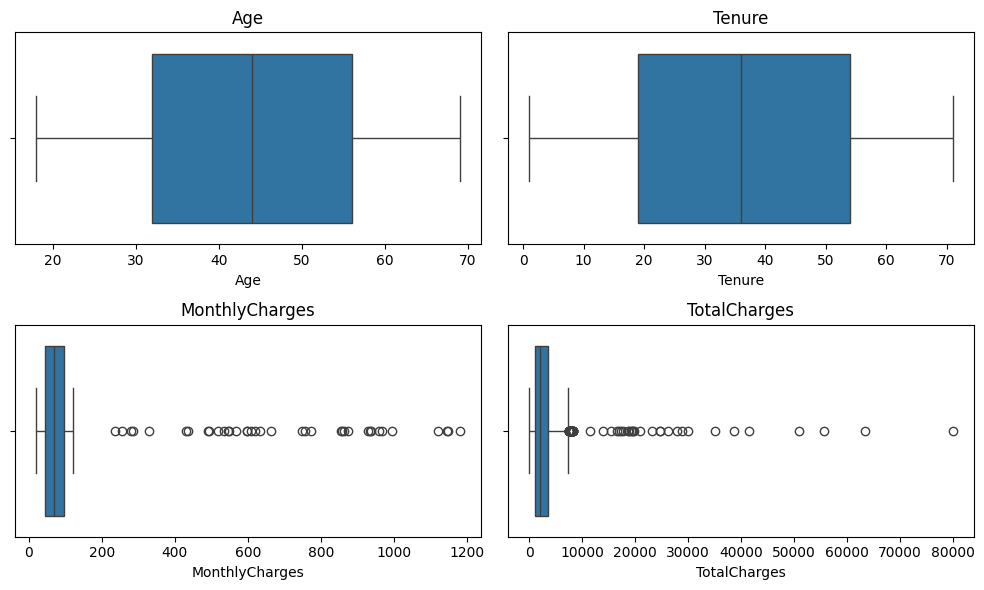

In [11]:


# Ensure 'numerical_feature' is defined and contains correct column names
# For example:
numerical_feature = ['Age','Tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(10, 6))
for i, feature in enumerate(numerical_feature, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[feature])  # Use 'feature' to access column
    plt.title(feature)

plt.tight_layout()
plt.show()

In [12]:
def replace_outliers_with_median(data, column):
    # Check if column exists in the DataFrame
    if column not in data.columns:
        print(f"Column '{column}' not found in the DataFrame!")
        return data

    # Ensure the column is numeric
    if not np.issubdtype(data[column].dtype, np.number):
        print(f"Column '{column}' is not numeric, skipping...")
        return data

    # Calculate the first and third quartiles
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate the median value for the column
    median_value = data[column].median()

    # Replace outliers with the median
    data[column] = np.where(
        (data[column] < lower_bound) | (data[column] > upper_bound),
        median_value,
        data[column]
    )

    return data

# Loop over the numerical features and apply the outlier replacement
# Use 'numerical_feature' instead of 'numerical_features'
for feature in numerical_feature:
    data = replace_outliers_with_median(data, feature)

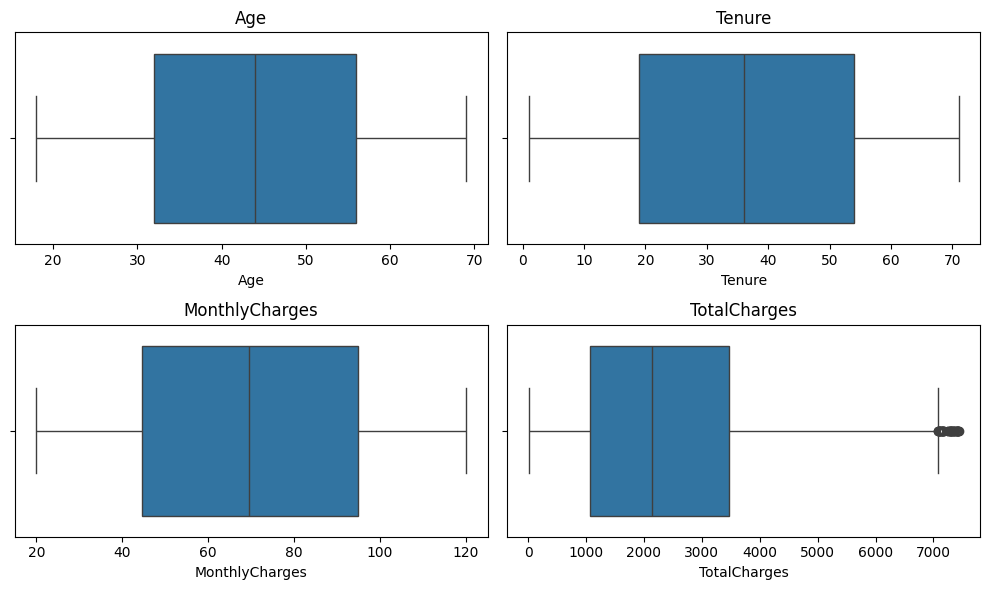

In [13]:
plt.figure(figsize=(10, 6))
# Iterate over the correct variable name 'numerical_feature'
for i, feature in enumerate(numerical_feature, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()


3. Exploratory Data Analysis (EDA)

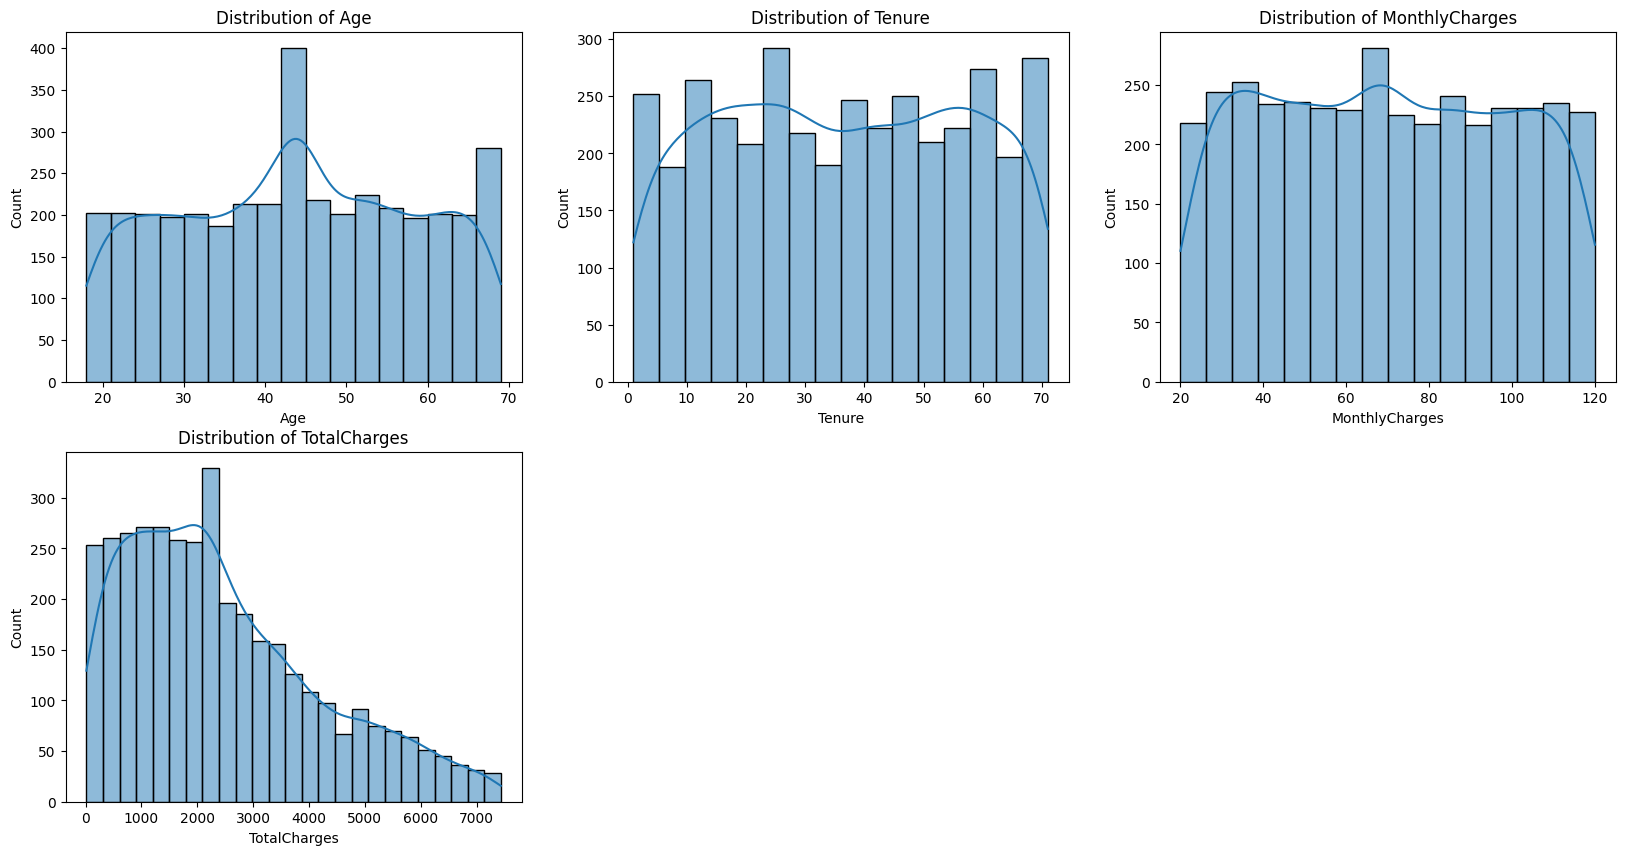

In [14]:
plt.figure(figsize=(20,10))
for i , col in enumerate(numerical_feature, 1):
    plt.subplot(2,3,i)
    sns.histplot(data[col],kde=True)
    plt.title(f'Distribution of {col}')
plt.show()

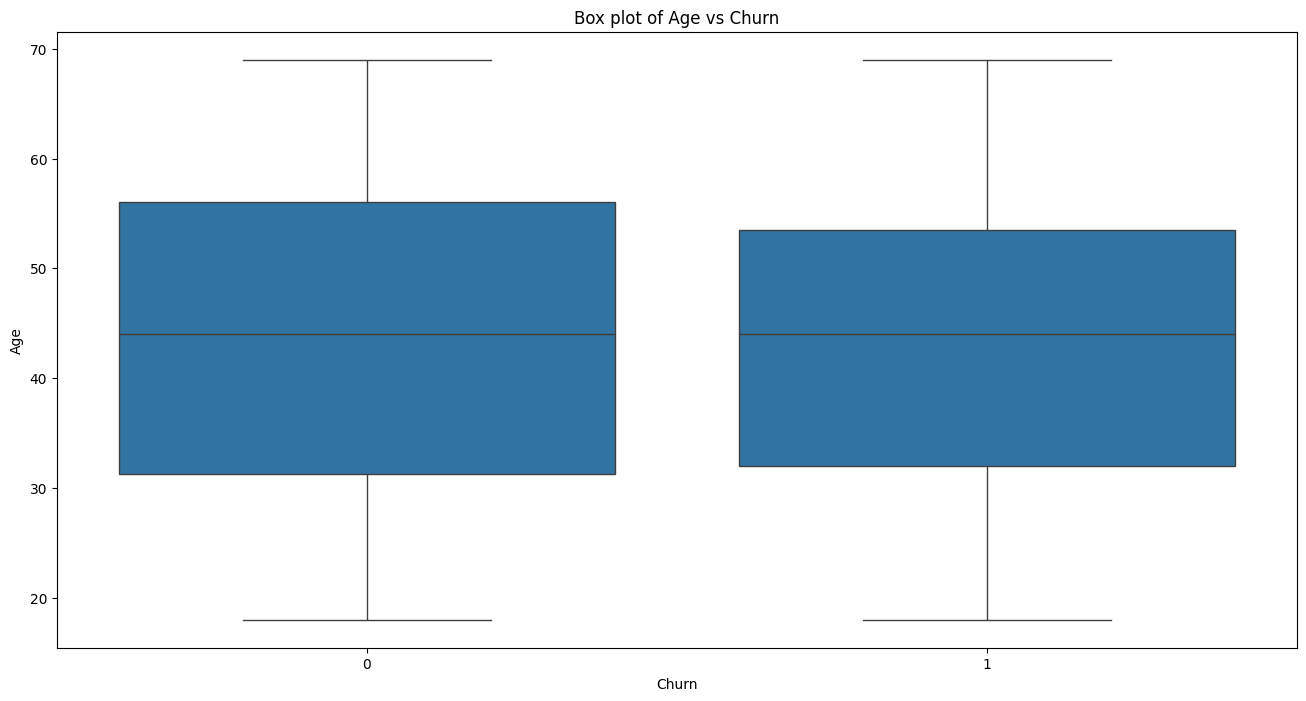

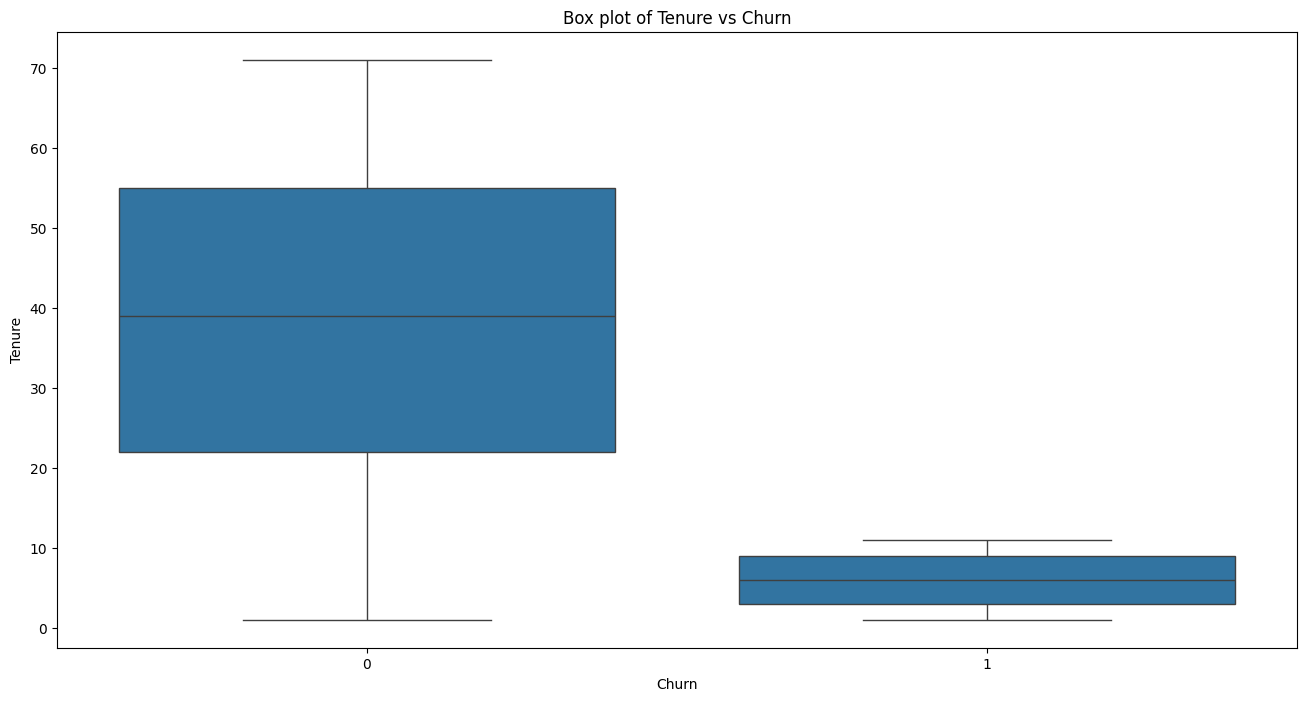

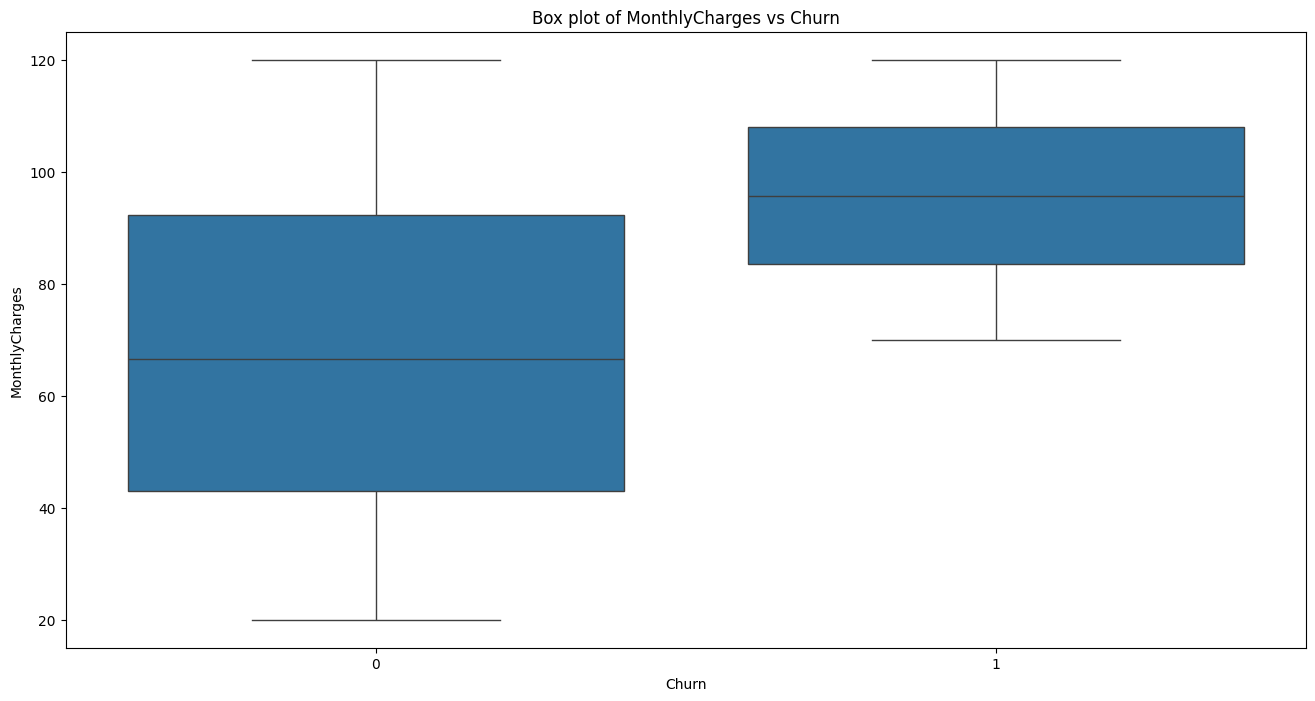

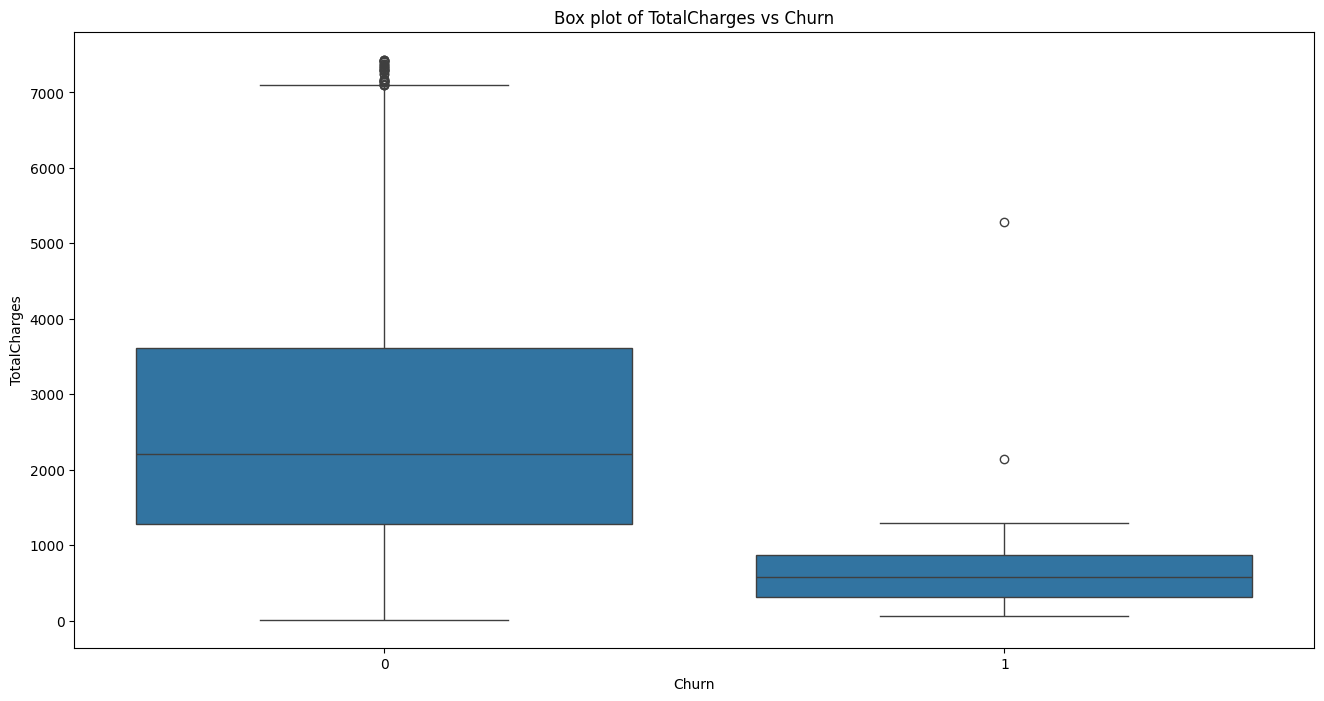

In [15]:
for feature in numerical_feature:
    plt.figure(figsize=(16,8))
    sns.boxplot(x='Churn', y=feature, data=data)
    plt.title(f'Box plot of {feature} vs Churn')
    plt.show()

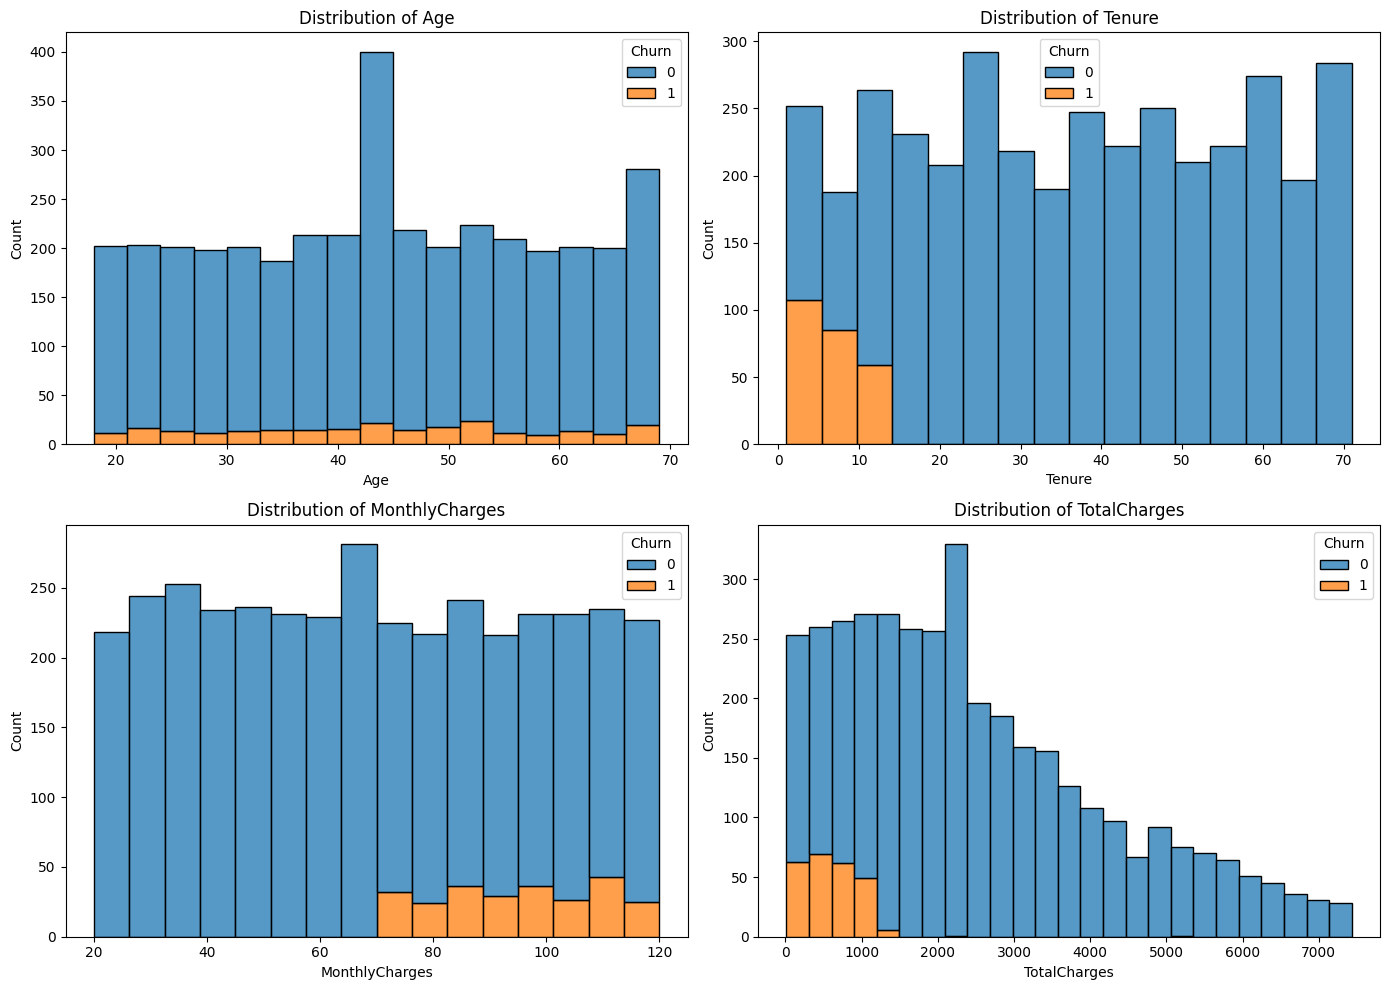

In [16]:
plt.figure(figsize=(14, 10))
for i,feature in enumerate(numerical_feature,1):
    plt.subplot(2,2,i)
    sns.histplot(data=data, x=feature, hue='Churn', multiple='stack')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

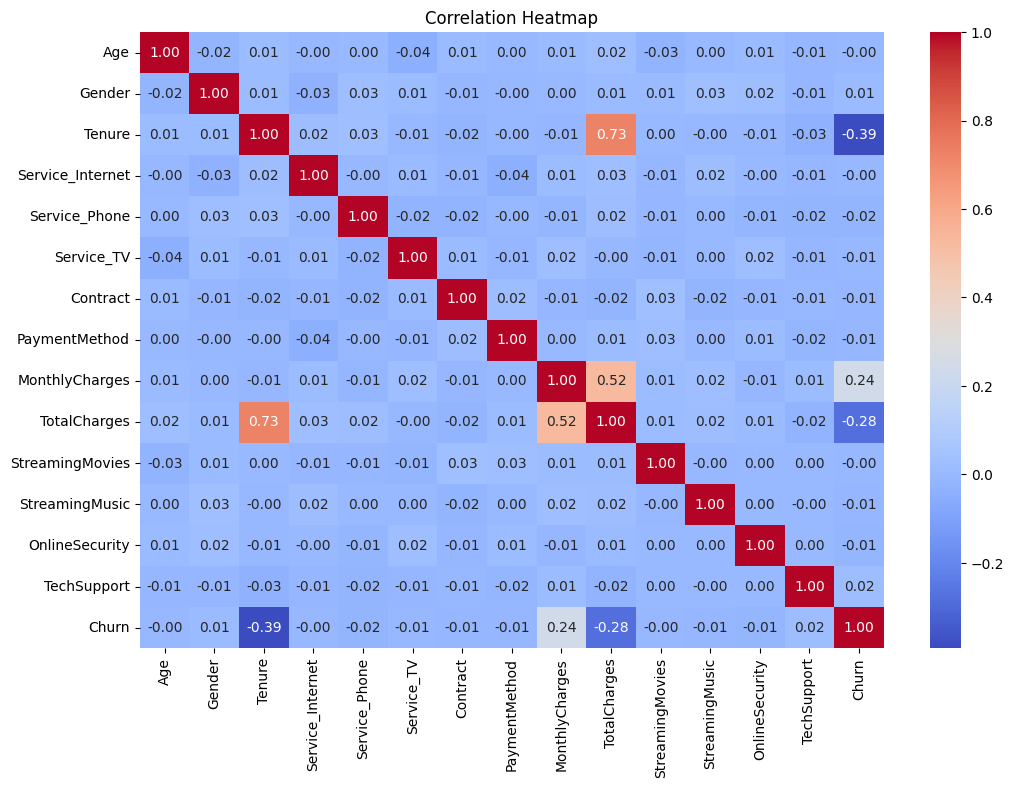

In [17]:
corr=data.corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

4. Feature Engineering

In [18]:
# Function to engineer new features
def feature_engineering(data):

    data['MonthlyCharges_per_Tenure'] = data['MonthlyCharges'] / (data['Tenure'] + 1)

    data['TotalCharges_per_Tenure'] = data['TotalCharges'] / (data['Tenure'] + 1)

    # Total number of services
    data['TotalServices'] = (data['Service_Internet'] + data['Service_Phone'] + data['Service_TV'] +
                             data['StreamingMovies'] + data['StreamingMusic'] + data['OnlineSecurity'] + data['TechSupport'])

    # Flag for high probability of Churn status

    data['churn_high_probability'] = (data['Tenure'] <= 20).astype(int)

    return data


data = feature_engineering(data)

data.head()


,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,Churn,MonthlyCharges_per_Tenure,TotalCharges_per_Tenure,TotalServices,churn_high_probability
0,56.0,1,13.0,0,1,0,1,3,71.88,931.49,0,0,1,0,0,5.134286,66.535000,2,1
1,69.0,1,13.0,0,0,1,2,3,110.99,1448.46,1,1,0,0,0,7.927857,103.461429,3,1
2,46.0,1,60.0,1,0,1,0,3,116.74,6997.73,1,1,0,0,0,1.913770,114.716885,4,0
3,32.0,0,57.0,1,1,1,0,0,78.16,4452.13,0,1,0,1,0,1.347586,76.760862,5,0
4,60.0,1,52.0,1,1,1,2,2,30.33,1569.73,1,0,1,1,0,0.572264,29.617547,6,0


Splitting the data:

In [19]:

X = data.drop('Churn', axis=1)
y = data['Churn']

X.head()

,Age,Gender,Tenure,Service_Internet,Service_Phone,Service_TV,Contract,PaymentMethod,MonthlyCharges,TotalCharges,StreamingMovies,StreamingMusic,OnlineSecurity,TechSupport,MonthlyCharges_per_Tenure,TotalCharges_per_Tenure,TotalServices,churn_high_probability
0,56.0,1,13.0,0,1,0,1,3,71.88,931.49,0,0,1,0,5.134286,66.535000,2,1
1,69.0,1,13.0,0,0,1,2,3,110.99,1448.46,1,1,0,0,7.927857,103.461429,3,1
2,46.0,1,60.0,1,0,1,0,3,116.74,6997.73,1,1,0,0,1.913770,114.716885,4,0
3,32.0,0,57.0,1,1,1,0,0,78.16,4452.13,0,1,0,1,1.347586,76.760862,5,0
4,60.0,1,52.0,1,1,1,2,2,30.33,1569.73,1,0,1,1,0.572264,29.617547,6,0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

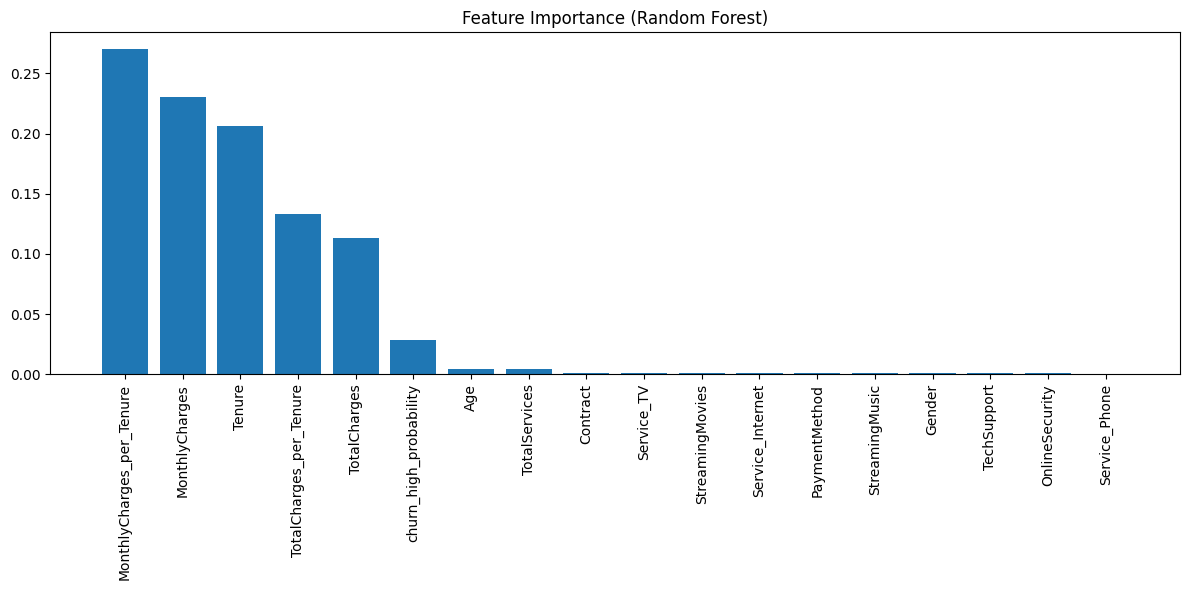

In [25]:
# Feature Importance for Random Forest or Decision Tree
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is already trained (e.g., RandomForestClassifier)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Calculate feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


Feature Selection:

In [21]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== Logistic Regression ===
╒══════════════════════════╤═════════╕
│ Metric                   │   Value │
╞══════════════════════════╪═════════╡
│ Accuracy                 │       1 │
├──────────────────────────┼─────────┤
│ Precision (Weighted Avg) │       1 │
├──────────────────────────┼─────────┤
│ Recall (Weighted Avg)    │       1 │
├──────────────────────────┼─────────┤
│ F1-Score (Weighted Avg)  │       1 │
╘══════════════════════════╧═════════╛




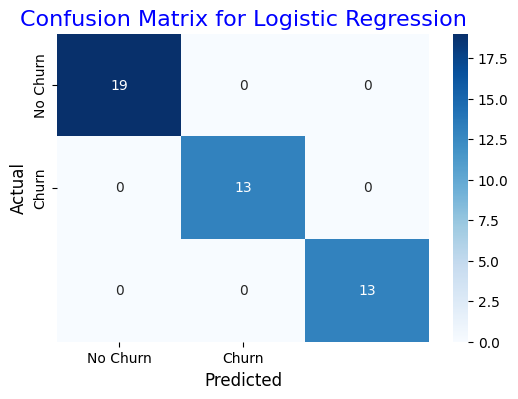

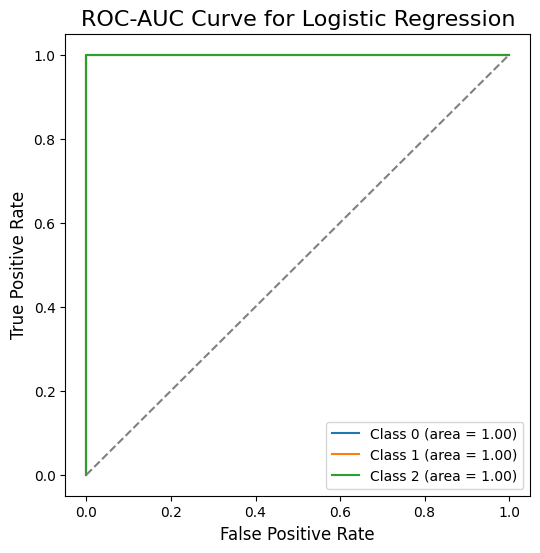

Micro-average ROC-AUC: 1.00
Macro-average ROC-AUC: 1.00

=== Decision Tree ===
╒══════════════════════════╤═════════╕
│ Metric                   │   Value │
╞══════════════════════════╪═════════╡
│ Accuracy                 │       1 │
├──────────────────────────┼─────────┤
│ Precision (Weighted Avg) │       1 │
├──────────────────────────┼─────────┤
│ Recall (Weighted Avg)    │       1 │
├──────────────────────────┼─────────┤
│ F1-Score (Weighted Avg)  │       1 │
╘══════════════════════════╧═════════╛




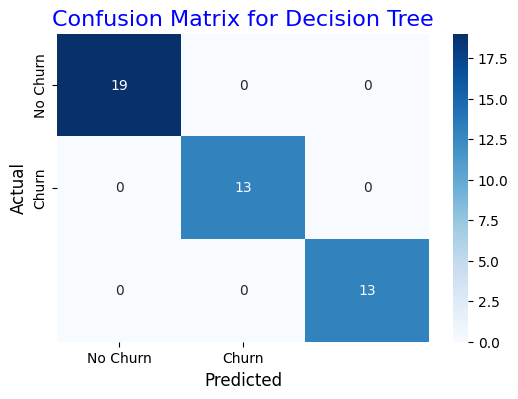

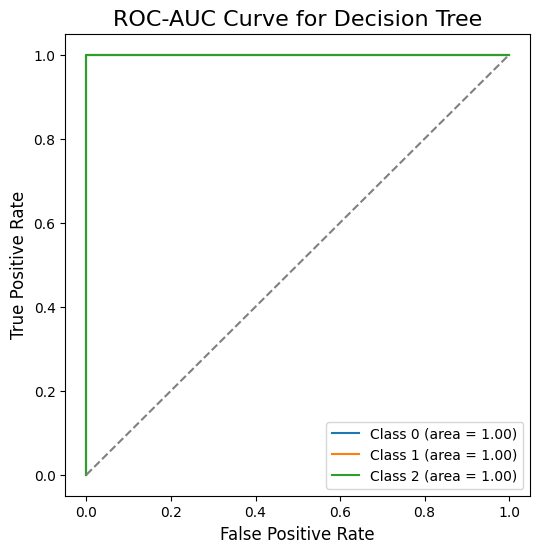

Micro-average ROC-AUC: 1.00
Macro-average ROC-AUC: 1.00

=== Random Forest ===
╒══════════════════════════╤═════════╕
│ Metric                   │   Value │
╞══════════════════════════╪═════════╡
│ Accuracy                 │       1 │
├──────────────────────────┼─────────┤
│ Precision (Weighted Avg) │       1 │
├──────────────────────────┼─────────┤
│ Recall (Weighted Avg)    │       1 │
├──────────────────────────┼─────────┤
│ F1-Score (Weighted Avg)  │       1 │
╘══════════════════════════╧═════════╛




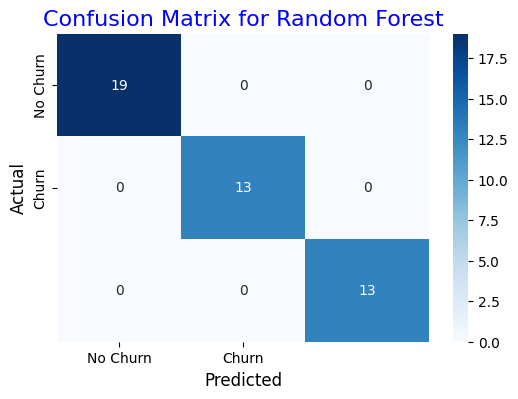

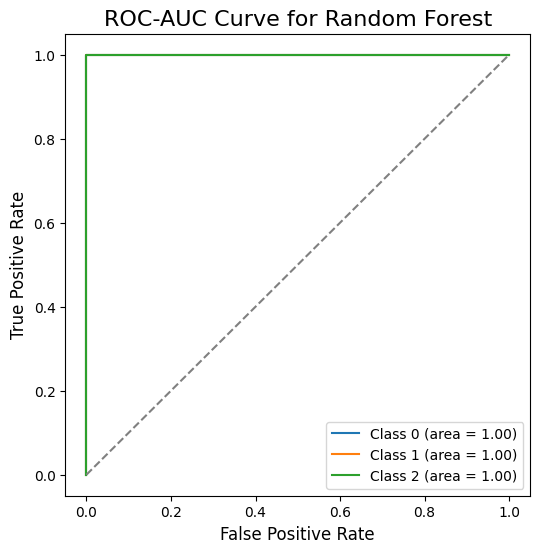

Micro-average ROC-AUC: 1.00
Macro-average ROC-AUC: 1.00

=== Support Vector Machine ===
╒══════════════════════════╤═════════╕
│ Metric                   │   Value │
╞══════════════════════════╪═════════╡
│ Accuracy                 │       1 │
├──────────────────────────┼─────────┤
│ Precision (Weighted Avg) │       1 │
├──────────────────────────┼─────────┤
│ Recall (Weighted Avg)    │       1 │
├──────────────────────────┼─────────┤
│ F1-Score (Weighted Avg)  │       1 │
╘══════════════════════════╧═════════╛




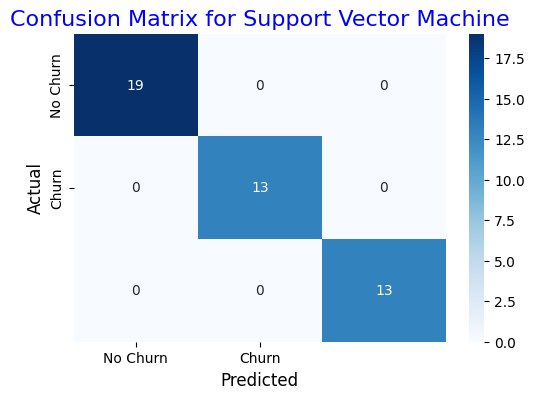

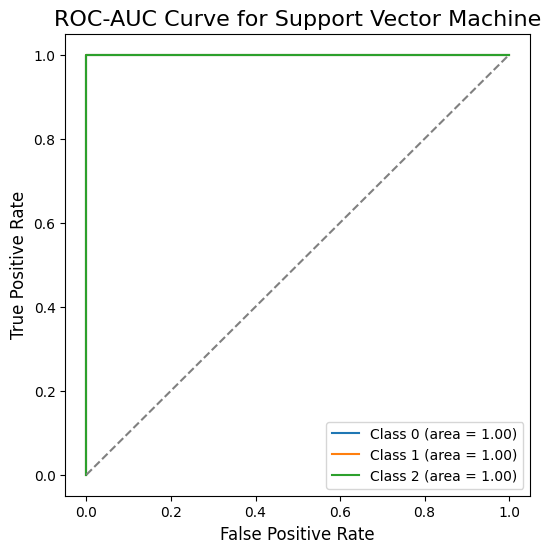

Micro-average ROC-AUC: 1.00
Macro-average ROC-AUC: 1.00


In [54]:

# Function to plot ROC-AUC curve for multiclass classification
def plot_multiclass_roc_auc(y_true, y_probs, model_name, n_classes):
    # Binarize the labels for one-vs-rest ROC curve
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
        roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_probs[:, i])

    # Plot ROC curve for each class
    plt.figure(figsize=(6, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random guess line
    plt.title(f"ROC-AUC Curve for {model_name}", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print macro and micro ROC-AUC scores
def calculate_macro_micro_roc_auc(y_true, y_probs, n_classes):
    # Binarize the labels for ROC-AUC calculation
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    # Calculate micro-average ROC-AUC
    roc_auc_micro = roc_auc_score(y_true_binarized, y_probs, average="micro")
    # Calculate macro-average ROC-AUC
    roc_auc_macro = roc_auc_score(y_true_binarized, y_probs, average="macro")

    print(f"Micro-average ROC-AUC: {roc_auc_micro:.2f}")
    print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")

# Training, predicting, and evaluating models
for model_name, model in {
    "Logistic Regression": log_reg,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Support Vector Machine": svm
}.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Predict probabilities for ROC-AUC calculation
    y_probs = model.predict_proba(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    display_metrics_table(model_name, accuracy, report)
    plot_confusion_matrix(y_test, y_pred, f"Confusion Matrix for {model_name}")

    # ROC-AUC and Curve Plot for Multiclass
    n_classes = len(set(y_train))  # Number of classes
    plot_multiclass_roc_auc(y_test, y_probs, model_name, n_classes)

    # Calculate and print macro and micro ROC-AUC
    calculate_macro_micro_roc_auc(y_test, y_probs, n_classes)


Evaluating Default Models...
Evaluating Tuned Models...

Logistic Regression - Default Model Performance
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       707
           1       0.66      0.95      0.78        43

    accuracy                           0.97       750
   macro avg       0.83      0.96      0.88       750
weighted avg       0.98      0.97      0.97       750



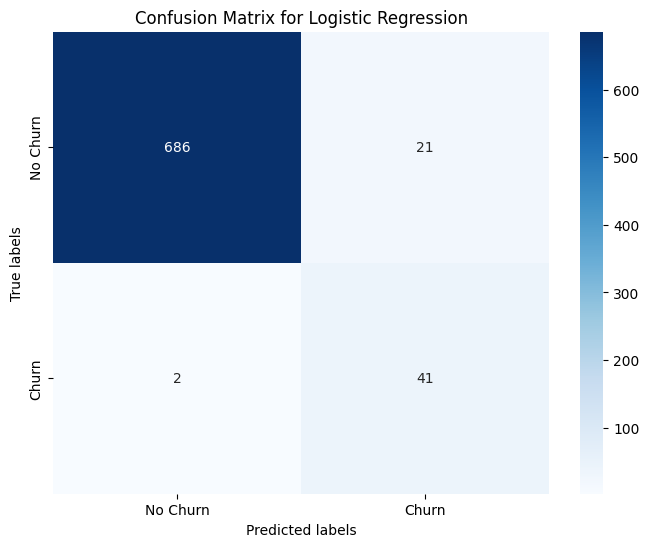


Decision Tree - Default Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.98      0.99        43

    accuracy                           1.00       750
   macro avg       1.00      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750



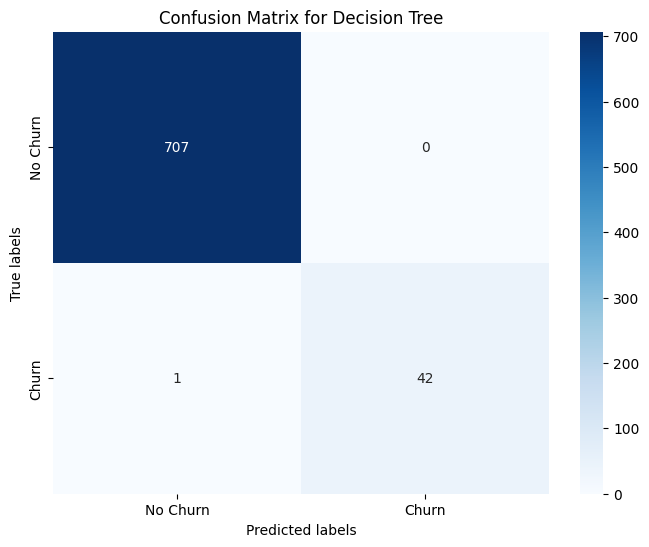


Random Forest - Default Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.98      0.99        43

    accuracy                           1.00       750
   macro avg       1.00      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750



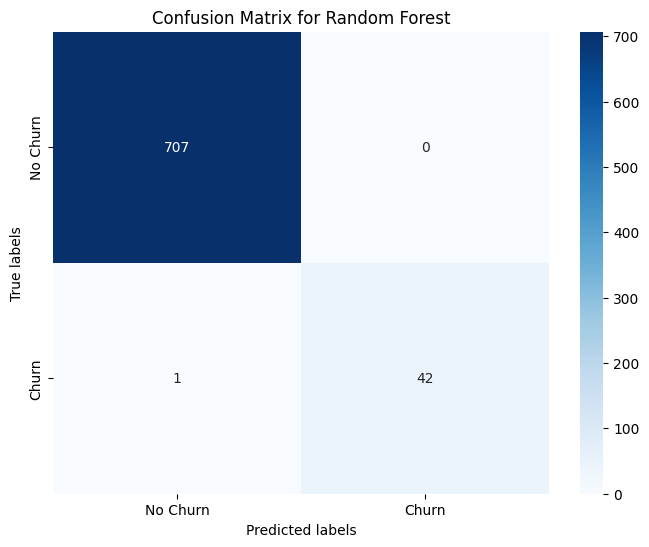


Support Vector Machine - Default Model Performance
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       707
           1       0.71      0.93      0.81        43

    accuracy                           0.97       750
   macro avg       0.85      0.95      0.90       750
weighted avg       0.98      0.97      0.98       750



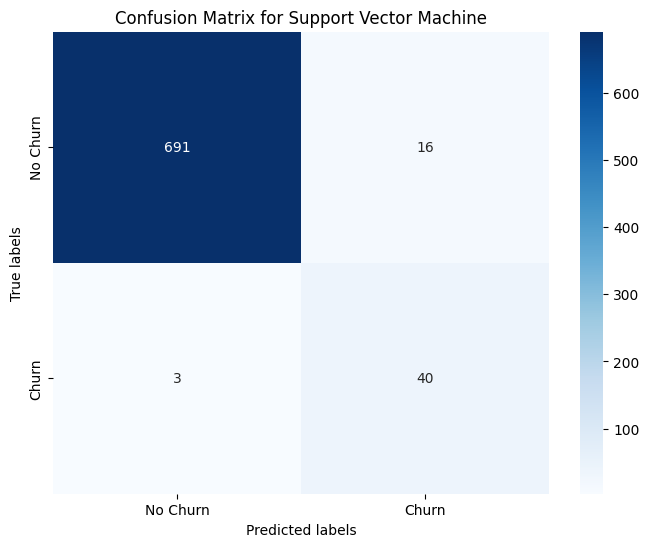


Tuned Logistic Regression - Tuned Model Performance
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       707
           1       0.66      0.95      0.78        43

    accuracy                           0.97       750
   macro avg       0.83      0.96      0.88       750
weighted avg       0.98      0.97      0.97       750



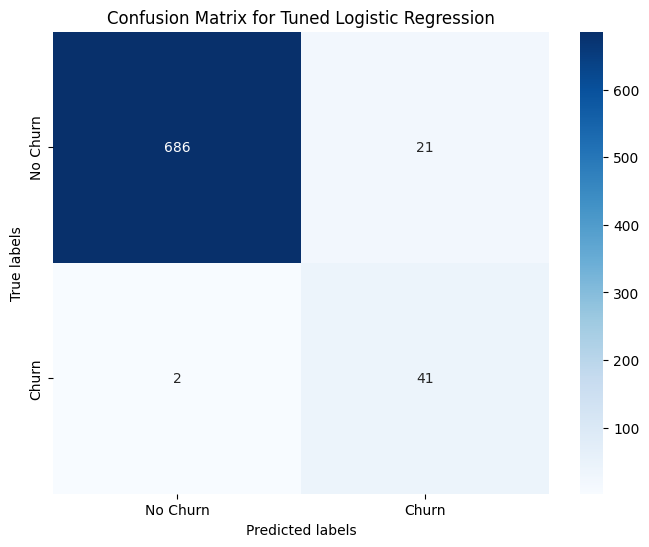


Tuned Decision Tree - Tuned Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      0.98      0.99        43

    accuracy                           1.00       750
   macro avg       1.00      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750



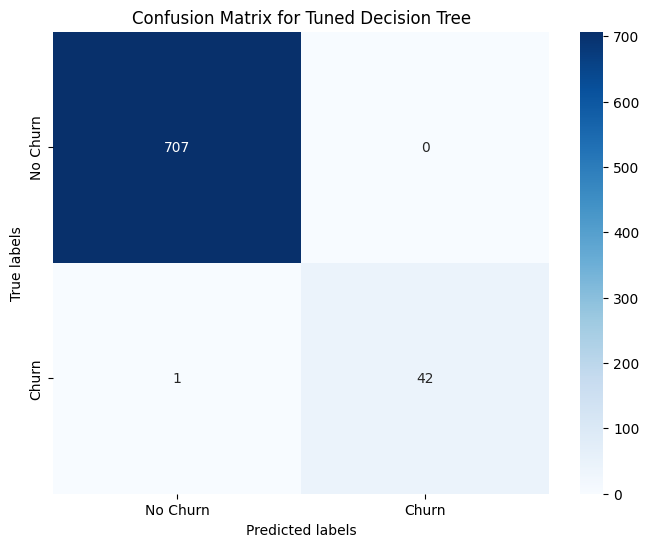


Tuned Random Forest - Tuned Model Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       707
           1       1.00      1.00      1.00        43

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



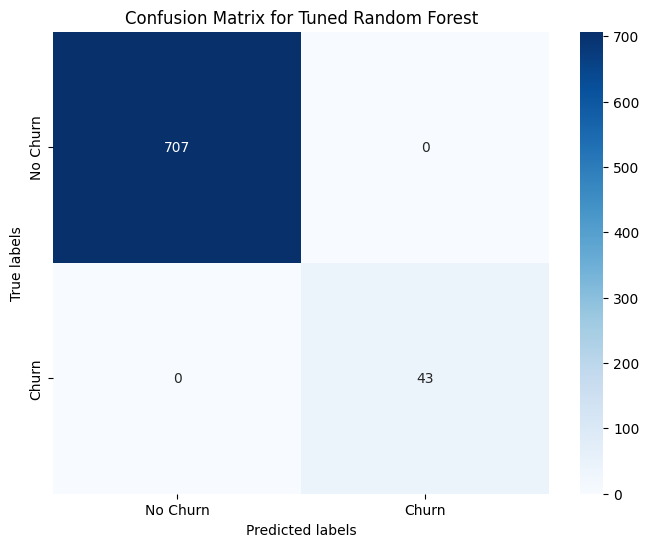


Tuned Support Vector Machine - Tuned Model Performance
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       707
           1       0.71      0.93      0.81        43

    accuracy                           0.97       750
   macro avg       0.85      0.95      0.90       750
weighted avg       0.98      0.97      0.98       750



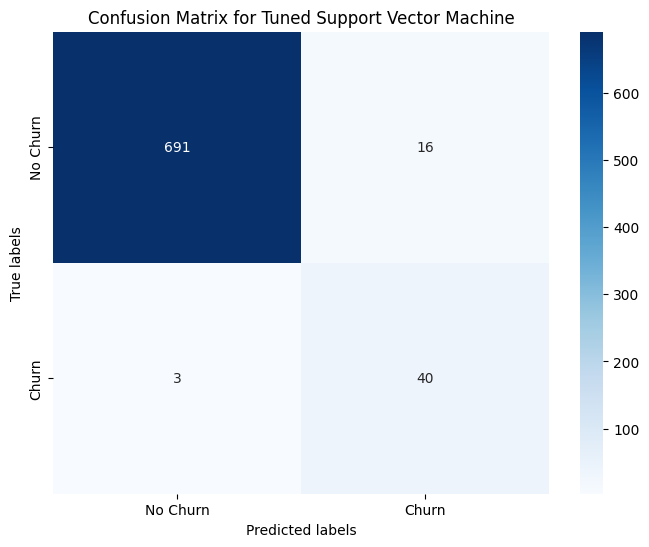

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compare performance
def compare_models(models, X_train, X_test, y_train, y_test):
    results = {}

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Get accuracy, classification report with zero_division=1, and confusion matrix
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=1)  # Handling undefined metrics
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Store results
        results[model_name] = {
            'accuracy': accuracy,
            'report': report,
            'conf_matrix': conf_matrix
        }

    return results

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    class_names = ["No Churn", "Churn"]  # Define class names
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Default models with increased max_iter and class_weight
default_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),  # Increased max_iter and balanced class weight
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(class_weight='balanced')  # Handle class imbalance
}

# Tuned models - Placeholder models for now. Replace with actual tuned models.
tuned_models = {
    "Tuned Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga'),  # Use 'saga' solver for tuning
    "Tuned Decision Tree": DecisionTreeClassifier(),  # Tuned Decision Tree
    "Tuned Random Forest": RandomForestClassifier(),  # Tuned Random Forest
    "Tuned Support Vector Machine": SVC(class_weight='balanced')  # Tuned SVM
}

# Evaluate default models
print("Evaluating Default Models...")
default_results = compare_models(default_models, X_train_scaled, X_test_scaled, y_train, y_test)

# Evaluate tuned models
print("Evaluating Tuned Models...")
tuned_results = compare_models(tuned_models, X_train_scaled, X_test_scaled, y_train, y_test)

# Print and compare results
for model_name in default_results:
    print(f"\n{model_name} - Default Model Performance")
    print(default_results[model_name]['report'])
    plot_confusion_matrix(default_results[model_name]['conf_matrix'], model_name)

for model_name in tuned_results:
    print(f"\n{model_name} - Tuned Model Performance")
    print(tuned_results[model_name]['report'])
    plot_confusion_matrix(tuned_results[model_name]['conf_matrix'], model_name)


In [24]:
import pickle
import os
# Create the directory if it doesn't exist
import os
os.makedirs('/content/drive/MyDrive/maschineL/model', exist_ok=True)

# Now you can safely save the models
pickle.dump(LogisticRegression, open('/content/drive/MyDrive/maschineL/model/Tuned LogisticRegression.pkl', 'wb'))
pickle.dump(DecisionTreeClassifier, open('/content/drive/MyDrive/maschineL/model/Tuned DecisionTreeClassifier.pkl', 'wb'))
pickle.dump(RandomForestClassifier, open('/content/drive/MyDrive/maschineL/model/Tuned RandomForestClassifier.pkl', 'wb'))
pickle.dump(SVC, open('/content/drive/MyDrive/maschineL/model/Tuned SVC.pkl','wb'))